In [1]:
import matplotlib.pyplot as plt
from statsmodels.api import add_constant, OLS, RLM
from statsmodels.nonparametric.kernel_regression import KernelReg
import pandas
import numpy
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import spearmanr

# This tutorial is organized into 6 sections meant to provide an overview of performing scaling analyses of biological and urban data. This is by no means comprehensive but if you decide to do a scaling project this should help you get started.

## The sections are as follows:

### 1. Intro to scaling
### 2. Estimating scaling parameters
### 3. Dealing with noisy data
### 4. Scale Adjusted Metropolitain Indicators (SAMIs)
### 5. Boundaries
### 6. Data Sources


## 1. Intro to scaling

To start lets look at the following data which is a list of mass in grams and basal metabilic rate from 391 species. (https://journals.biologists.com/jeb/article/160/1/25/5986/Size-and-Power-in-Mammals)

In [2]:
metabolism_mammals = pandas.read_csv('data/metabolism_mass_mammals.csv')[['species','M(g)','B(W)']]
metabolism_mammals

,species,M(g),B(W)
0,Bos taurus,347000.0,306.77
1,Camelus dromedarius,407000.0,229.18
2,Capreolus capreolus,21500.0,48.43
3,Cervus elaphu,67000.0,112.43
4,Connochaetes taurinus,140000.0,157.67
...,...,...,...
386,Thomomys umbrinus,95.3,0.46
387,Trichomys apereoides,323.0,1.16
388,Zapus hudsonicus,30.0,0.25
389,Ptilocercus lowii,57.5,0.24


In [3]:
metabolism_mammals.describe()

,M(g),B(W)
count,3.910000e+02,391.000000
mean,1.715901e+04,15.360230
std,1.885044e+05,122.041062
min,2.500000e+00,0.040000
25%,4.144500e+01,0.310000
50%,1.578000e+02,0.740000
75%,1.582000e+03,3.400000
max,3.672000e+06,2336.500000


We can see that the mass of mammals in this dataset ranges from 2.5 grams (Etruscan Shrew) to almost 4 million grams (Asian Elephant). This creates problems when we try and visualize the data.

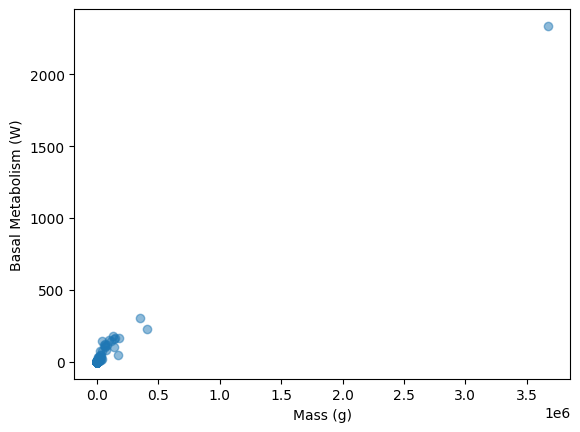

In [4]:
plt.clf()
plt.scatter(metabolism_mammals['M(g)'],metabolism_mammals['B(W)'],alpha=.5)
plt.xlabel('Mass (g)')
plt.ylabel('Basal Metabolism (W)')
plt.show()

Lets zoom in.

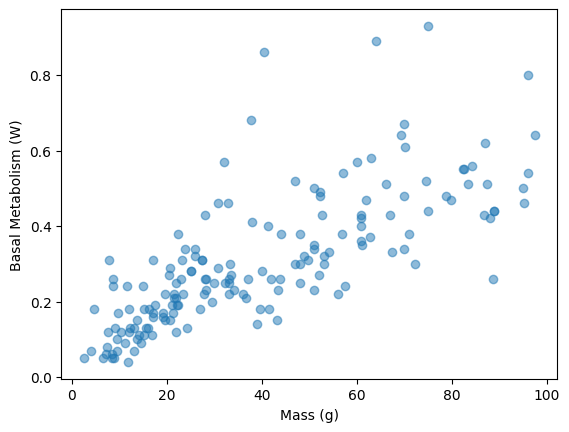

In [5]:
plt.clf()
plt.scatter(metabolism_mammals['M(g)'][metabolism_mammals['M(g)']<100],
            metabolism_mammals['B(W)'][metabolism_mammals['M(g)']<100],alpha=.5)
plt.xlabel('Mass (g)')
plt.ylabel('Basal Metabolism (W)')
plt.show()

That is much better. On my screen the 20g increments take up about 1.5 cm. That means that I would need a monitor around 25 km wide to display all of the data!

The solution is to log-transform our data so that each tick on our plot is an order of magnitude.

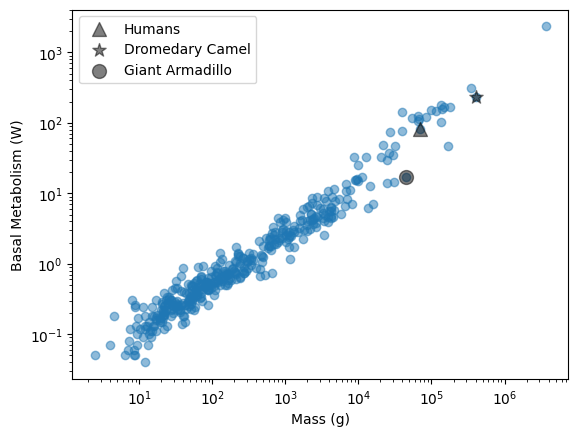

In [6]:
plt.clf()
plt.scatter(metabolism_mammals['M(g)'],
            metabolism_mammals['B(W)'],alpha=.5)
plt.scatter(metabolism_mammals['M(g)'][metabolism_mammals['species'].str.contains('Homo sap')],
            metabolism_mammals['B(W)'][metabolism_mammals['species'].str.contains('Homo sap')],marker='^',label='Humans',color='k',alpha=.5,s=100)
plt.scatter(metabolism_mammals['M(g)'][metabolism_mammals['species'].str.contains('Camelus dromedarius')],
            metabolism_mammals['B(W)'][metabolism_mammals['species'].str.contains('Camelus dromedarius')],marker='*',label='Dromedary Camel',color='k',alpha=.5,s=100)
plt.scatter(metabolism_mammals['M(g)'][metabolism_mammals['species'].str.contains('Priodontes maximus')],
            metabolism_mammals['B(W)'][metabolism_mammals['species'].str.contains('Priodontes maximus')],marker='o',label='Giant Armadillo',color='k',alpha=.5,s=100)
plt.xlabel('Mass (g)')
plt.ylabel('Basal Metabolism (W)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Now we can see all of the data at once. It is immediately clear that it falls on a straight line.

If the data are indeed on straight line, this means that we can write the relationship between the metabolism and the mass as:

$ln(B_i) = ln(C)+\beta ln(M_i) + ln(\xi_i)$

or equivalently:

$B_i = C M_i^\beta\xi_i$

Where $C$ is the scaling prefactor, $\beta$ the scaling exponent, and $\xi_i$ the scaling residuals.

We call this a scale invariant relationship or a power law because if we increase mass, say by multiplying by 2, we get:

$\frac{B_i(2M_i)}{B_i(M_i)} = \frac{C (2M_i)^\beta\xi_i}{C (M_i)^\beta\xi_i} = 2^\beta$.

So that regardless of the starting scale (mass) doubling the mass always results in the same $2^\beta$ increase in the metabolism.



## 1.  Estimating scaling parameters

The most common way to measure the slope of this line, the scaling exponent, and the intercept, the prefactor is by ordinary least squares regression. Note that we cannot have data with a mass of 0 or a metabolism of 0 because of the log transformation.

In [7]:
mammal_fit = OLS(numpy.log(metabolism_mammals['B(W)']),add_constant(numpy.log(metabolism_mammals['M(g)']))).fit()
mammal_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   B(W)   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     7731.
Date:                Mon, 27 May 2024   Prob (F-statistic):          9.07e-259
Time:                        17:14:26   Log-Likelihood:                -194.76
No. Observations:                 391   AIC:                             393.5
Df Residuals:                     389   BIC:                             401.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8592      0.050    -77.476      0.000      -3.957      -3.761
M(g)           0.7100      0.008     87.924      0.000       0.694       0.726
==============================================================================
Omnibus:                        5.088   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.648
Skew:                           0.156   Prob(JB):                       0.0594
Kurtosis:                       3.499   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The intercept (conts) tells us the expected metabolic rate for an organism of mass 1 gram: .021 W.

The coefficient on the mass tells us the scaling exponent which is close to the theoretically predicted value of 3/4 (https://www.science.org/doi/full/10.1126/science.276.5309.122).

One important thing to check with this model is that the scaling residuals are not correlated with the scale variable, mass in this case.

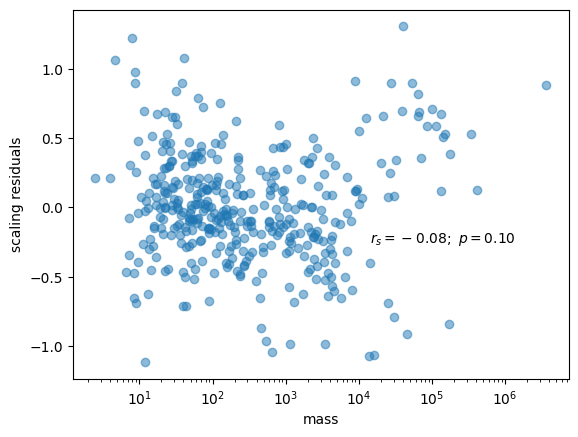

In [8]:
plt.clf()
plt.scatter(metabolism_mammals['M(g)'],mammal_fit.resid,alpha=.5)
correlation = spearmanr(metabolism_mammals['M(g)'],mammal_fit.resid)
plt.ylabel('scaling residuals')
plt.xlabel('mass')
plt.xscale('log')
plt.text(14000,-.25,r'$r_s = %.2f;\ p=%.2f$' % (correlation[0],correlation[1]))
plt.show()

If there is a correlation between the residuals and the scale variable it could be a sign of some issue with the data, or it could signal that a scaling relationship is not a good description of the data.

It is also useful to check that the residuals are roughly normally desributed, though this is not a necessity. 

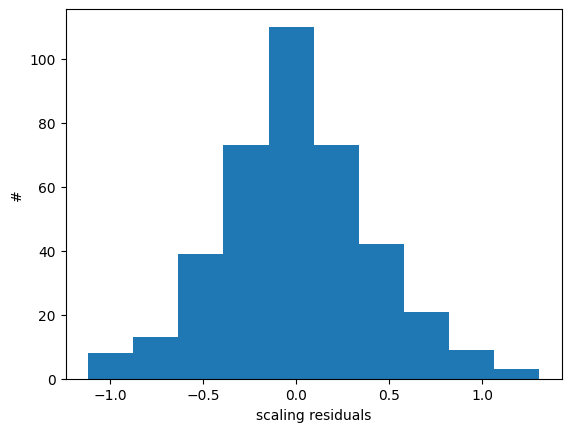

In [9]:
plt.clf()
plt.hist(mammal_fit.resid)
plt.xlabel('scaling residuals')
plt.ylabel('#')
plt.show()

You can also choose your favorite test for normality and run that on the residuals:

In [10]:
from scipy.stats import normaltest
normaltest(mammal_fit.resid)

NormaltestResult(statistic=5.088166923949426, pvalue=0.07854500848722137)

Another option is to look at quantile-quantile plots which plots the quantiles of the data against the quantiles of the normal distribution. This should be a straight line if the data are normally distributed.

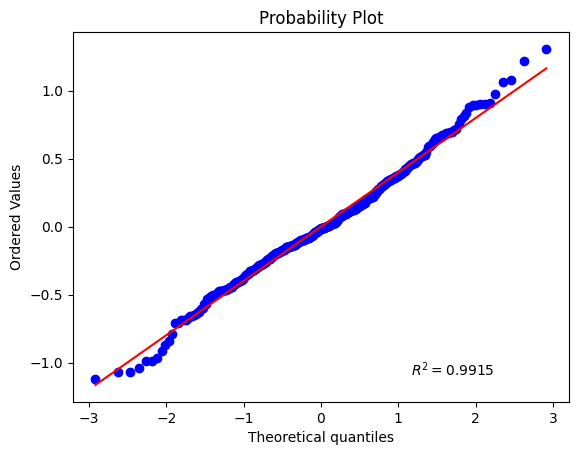

In [11]:
from scipy.stats import probplot
probplot(mammal_fit.resid, dist="norm",plot=plt,rvalue=True)
plt.show()

Notice that the larger mass mammals tend to be above the line while the smaller mass mammals tend to be below the line. This suggests that there may be something interesting happening at the largest and smallest scales. This is most likely due to sampling differences related to the number of mammal species of various sizes, however in other cases, such differences may be signaling interesting phenomena.

## 3. Dealing with noisy data

Before we switch to looking at data from cities, we will breifly discuss a few other types of regression models that are commonly used for scaling analyses.

If you have small quantities of data or significant outliers that you don't want to explicitly exclude from the regression, one option is Robust Least Squares regression. The statsmodels package has a built in RLM class to run this type of regression with multiple choices for how to downweight outliers.

For the mamall data the resuts are esentially the same as for OLS since there are few large outliers.

In [12]:
mammal_fit = RLM(numpy.log(metabolism_mammals['B(W)']),add_constant(numpy.log(metabolism_mammals['M(g)']))).fit()
mammal_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   B(W)   No. Observations:                  391
Model:                            RLM   Df Residuals:                      389
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 27 May 2024                                         
Time:                        17:14:27                                         
No. Iterations:                    19                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8739      0.049    -79.715      0.000      -3.969      -3.779
M(g)           0.7113      0.008     90.287      0.000       0.696       0.727
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Another common case is when you would like to account for the variance of the both the x and y variables. One option is standard major axis regression (SMA) which minimizes the perpendicular distance between the data points and the regression line. The scipy package calls this orthogonal distance regression or ODR.

In [13]:
from scipy.odr import ODR, Data, Model
def f(B, x):
    return B[1]*x + B[0]

odr_fit = ODR(Data(numpy.log(metabolism_mammals['M(g)']),numpy.log(metabolism_mammals['B(W)']),
                  wd=1./(numpy.log(metabolism_mammals['B(W)']).std()**2),
                   we=1./(numpy.log(metabolism_mammals['M(g)']).std()**2)),Model(f),beta0=[1,1]).run()
odr_fit.pprint()

Beta: [-3.90203859  0.71758909]
Beta Std Error: [0.04991597 0.00809348]
Beta Covariance: [[ 0.12440416 -0.01844351]
 [-0.01844351  0.00327059]]
Residual Variance: 0.020028299414867553
Inverse Condition #: 0.06025033366926514
Reason(s) for Halting:
  Sum of squares convergence


Another common occurence is having persistent noise in your data beyond a few outliers. Often there is much more noise at smaller scales dues to sample size differences or measurement precision relative to scale. This often happens when looking at urban data: smaller cities tend to have few samples than larger cities and so the measurements have different amounts of noise relative to the means.

We can simulate this by adding constant size random noise to the mammal data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


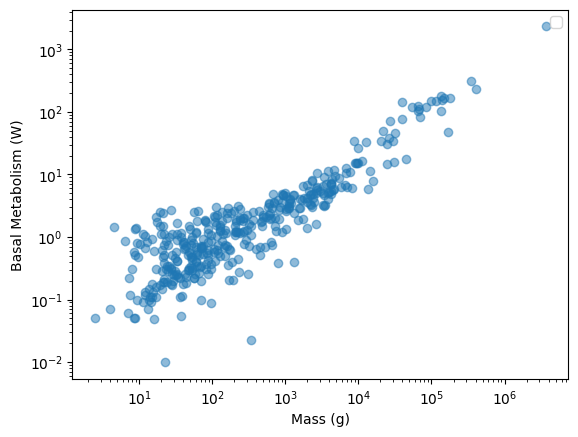

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   B(W)   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     1374.
Date:                Mon, 27 May 2024   Prob (F-statistic):          9.97e-130
Time:                        17:14:28   Log-Likelihood:                -479.36
No. Observations:                 391   AIC:                             962.7
Df Residuals:                     389   BIC:                             970.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0909      0.103    -29.967      0.000      -3.294      -2.888
M(g)           0.6198      0.017     37.071      0.000       0.587       0.653
==============================================================================
Omnibus:                       33.927   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.540
Skew:                          -0.332   Prob(JB):                     1.21e-23
Kurtosis:                       5.457   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
plt.clf()
noisyY = metabolism_mammals['B(W)']+numpy.random.normal(.1,1,len(metabolism_mammals['B(W)']))
noisyY[noisyY<0] = metabolism_mammals['B(W)'][noisyY<0]
plt.scatter(metabolism_mammals['M(g)'],
            noisyY,alpha=.5)
plt.xlabel('Mass (g)')
plt.ylabel('Basal Metabolism (W)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

OLS(numpy.log(noisyY),add_constant(numpy.log(metabolism_mammals['M(g)']))).fit().summary()

We can clearly see that this impacts our ability to measure the scaling exponent.

Lets see how bad this is as we increase the amount of noise in the measurements.

In [15]:
noisy_metabolism_fits = []
sds = numpy.logspace(numpy.log10(.15),numpy.log10(2),10)
for sd in sds:
    slopes = []
    for i in range(100):
        noisyY = metabolism_mammals['B(W)']+numpy.random.normal(.04,sd,len(metabolism_mammals['B(W)']))
        noisyY[noisyY<0] = metabolism_mammals['B(W)'].values[noisyY<0]
        slopes.append(OLS(numpy.log(noisyY),add_constant(numpy.log(metabolism_mammals['M(g)']))).fit().params.values[1])
    noisy_metabolism_fits.append(slopes)


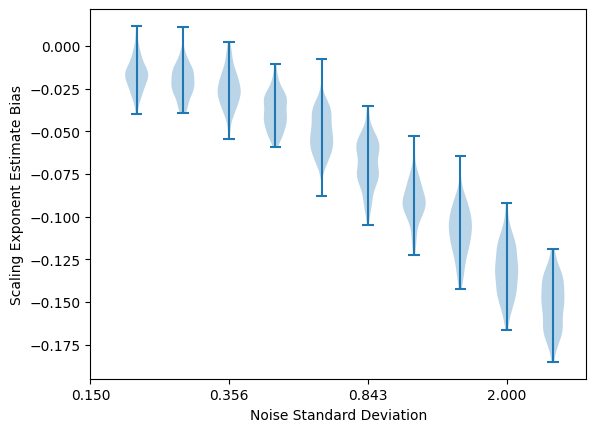

In [16]:
plt.clf()
plt.violinplot([numpy.array(x) - mammal_fit.params.values[1] for x in noisy_metabolism_fits])
plt.xticks(list(range(len(sds)))[::len(sds)//3],["%.3f" % x for x in sds[::len(sds)//3]])
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Scaling Exponent Estimate Bias')
plt.show()

The more noise that exists in the data the more biased our scaling estimate becomes. In this case we estimate a much smaller scaling exponent than the true data generating mechanism.

If you have many noisy observations, one option is to smooth the data (i.e. average) to reduce the impact of noise on the estimate of scaling parameters.  

The statsmodels package has a class to do this called KernelReg. When you set the reg_type='lc' this is Nadaraya–Watson kernel regression.

In [17]:
smoothed_noisy_metabolism_fits = []
for sd in sds:
    slopes = []
    for i in range(25):
        noisyY = metabolism_mammals['B(W)']+numpy.random.normal(.04,sd,len(metabolism_mammals['B(W)']))
        noisyY[noisyY<0] = metabolism_mammals['B(W)'].values[noisyY<0]
        x_pred = numpy.linspace(numpy.log(metabolism_mammals['M(g)']).min(),numpy.log(metabolism_mammals['M(g)']).max(),25)
        kr = KernelReg(numpy.log(noisyY),numpy.log(metabolism_mammals['M(g)']),var_type='c',reg_type='lc').fit(x_pred)
        slopes.append(OLS(kr[0],add_constant(x_pred)).fit().params[1])
    print('done with %.3f' % sd)
    smoothed_noisy_metabolism_fits.append(slopes)

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x


done with 0.150
done with 0.200
done with 0.267
done with 0.356
done with 0.474
done with 0.632
done with 0.843
done with 1.125
done with 1.500
done with 2.000


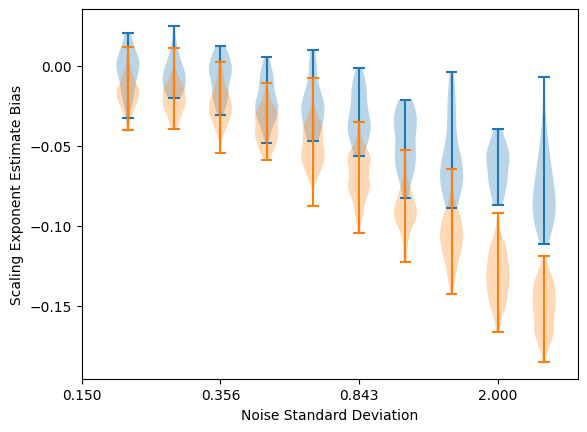

In [18]:
plt.clf()
plt.violinplot([numpy.array(x) - mammal_fit.params.values[1] for x in smoothed_noisy_metabolism_fits])
plt.violinplot([numpy.array(x) - mammal_fit.params.values[1] for x in noisy_metabolism_fits])
plt.xticks(list(range(len(sds)))[::len(sds)//3],["%.3f" % x for x in sds[::len(sds)//3]])
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Scaling Exponent Estimate Bias')
plt.show()

We can see that smoothing with Nardarya-Watson kernel regression helps quite a bit to remove the bias that was created by the noise, but it can't help us completely if our data are too noisy. 

### A Breif Aside on Fitting Power Laws

One thing to also note is that you may come across the paper by Clauset Shalizi and Newman (other SFI people) on fitting power laws distributions in empirical data (https://epubs.siam.org/doi/abs/10.1137/070710111).

This paper is wonderful, but not always applicable when doing the types of scaling analyses discussed here. In particular, that paper discussing fitting power law distributions: the number of species of a certain mass, the number of cities with a certain population, the number of friends a resident of a particular city is likely to have, etc. 

These quantities can all be formulated as probability distributions, in which case that paper is very useful for understanding whether the empirical data point to power law distributions or other functional forms.

To summarize, that paper is concerned with question of how scale or size relate to a thing's probability of existence. In contrast, scaling analysis as discussed here refers to how scale or size influences some functional measurement of a thing.

We are interested in the matabolism, reproductive timing, lifespan, etc as a function of the bodyweight of an organism. Or the mean number of friends, total number of crimes, total number of pattents, etc as a function of the population of a city. 

While these distributional questions are not unrelated (see https://www.nature.com/articles/s41467-020-18205-1) they are not the main focus here.

## 4. Scale Adjusted Metropolitain Indicators (SAMIs)

We switch to an urban datset next to discuss an analysis of the residuals.

This data is income data (not just wages, but includes investment and real estate income) for 2010 to 2022 and  population data for the same time period.

Note that we are using the core-based statistical area definition for U.S. cities. The idea is to capture the extended socio-economic influence of the core city area. We will discuss boundaries more extensively in the next section.

In [19]:
years = list(range(2010,2023))
income_data_usa = [pandas.read_csv('data/aggregated_income_data/ACSDT5Y%d.B19313-Data.csv' % year) for year in years]
for i in range(len(income_data_usa)):
    income_data_usa[i]['year'] = years[i]
income_data_usa = pandas.concat(income_data_usa)
income_data_usa = income_data_usa[['GEO_ID',"B19313_001E", "year"]]
income_data_usa = income_data_usa.rename(columns={'B19313_001E': 'aggregated_income'})

pop_data_usa = [pandas.read_csv('data/population_data/ACSDT5Y%d.B01003-Data.csv' % year) for year in years]
for i in range(len(pop_data_usa)):
    pop_data_usa[i]['year'] = years[i]
pop_data_usa = pandas.concat(pop_data_usa)
pop_data_usa = pop_data_usa[['GEO_ID',"B01003_001E","year"]]
pop_data_usa = pop_data_usa.rename(columns={'B01003_001E': 'population'})

usa_data = pop_data_usa.set_index(['GEO_ID', "year"]).join(income_data_usa.set_index(['GEO_ID', "year"])).reset_index()
usa_data = usa_data[~usa_data['GEO_ID'].str.contains('Geography')]
usa_data['GEO_ID'] = usa_data['GEO_ID'].map(lambda x: x.split('US')[-1])

cbsa_names = pandas.read_csv('data/cbsas.csv')
cbsa_names['CBSA Code'] = cbsa_names['CBSA Code'].astype(str)
usa_data = usa_data.set_index('GEO_ID').join(cbsa_names[['CBSA Code', 'CBSA Name']].set_index('CBSA Code')).reset_index()
usa_data = usa_data[~usa_data['CBSA Name'].str.contains(', PR').astype(bool)]

Let's first plot the data to see how things look

<Figure size 640x480 with 0 Axes>

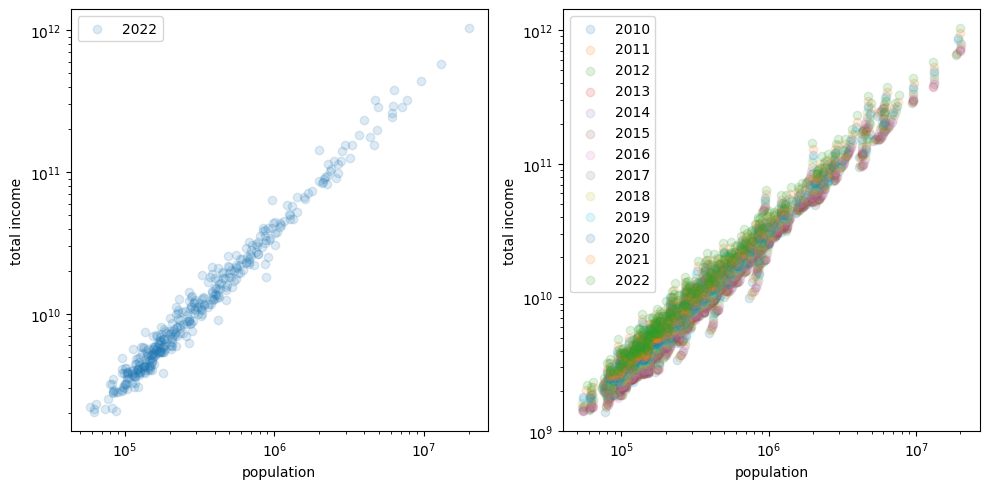

In [20]:
plt.clf()
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
[plt.scatter(usa_data[usa_data['year']==y]['population'].astype(float),usa_data[usa_data['year']==y]['aggregated_income'].astype(float),alpha=.15,label=y) for y in [years[-1]]]
plt.yscale('log')
plt.xscale('log')
plt.xlabel('population')
plt.ylabel('total income')
plt.legend()
plt.subplot(1,2,2)
[plt.scatter(usa_data[usa_data['year']==y]['population'].astype(float),usa_data[usa_data['year']==y]['aggregated_income'].astype(float),alpha=.15,label=y) for y in years]
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('population')
plt.ylabel('total income')
plt.tight_layout()
plt.show()

We can already see that there are trends of increasing income with time in the right plot. We can mean center in log-space i.e., devide my the mean to get a better sense of the change in the scaling relationship over time.

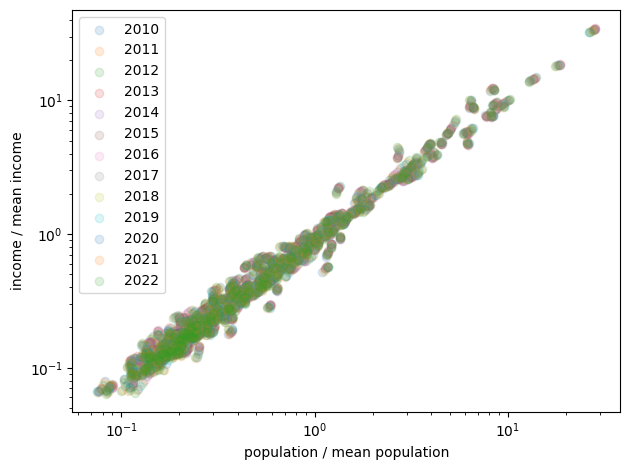

In [21]:
plt.clf()
[plt.scatter(usa_data[usa_data['year']==y]['population'].astype(float)/usa_data[usa_data['year']==y]['population'].astype(float).mean(),usa_data[usa_data['year']==y]['aggregated_income'].astype(float)/usa_data[usa_data['year']==y]['aggregated_income'].astype(float).mean(),alpha=.15,label=y) for y in years]
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('income / mean income')
plt.xlabel('population / mean population')
plt.tight_layout()
plt.show()

What we see is that once we mean center, the data from each year roughly collapses to a single line. This suggests that the scaling exponent is not changing over time but the prefactor is changing over time.

Let's check this explicitly.

In [22]:
scaling_fits = [RLM(numpy.log(usa_data[usa_data['year']==y]['aggregated_income'].astype(float)),add_constant(numpy.log(usa_data[usa_data['year']==y]['population'].astype(float)))).fit() for y in years]

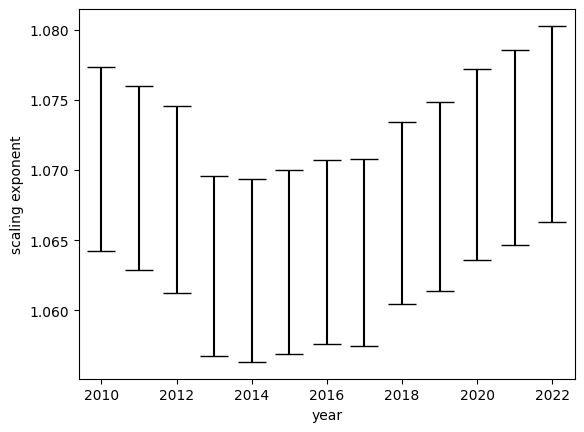

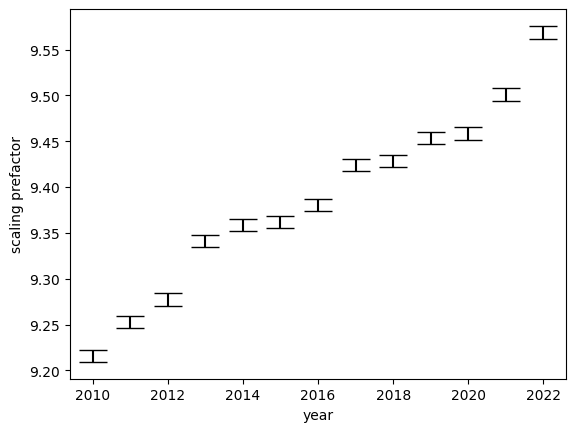

In [23]:
plt.clf()
plt.errorbar(years,
             [x.params.values[1] for x in scaling_fits],
             [x.bse.values[1] for x in scaling_fits],
             capsize=10,linestyle='', color='k')
plt.xlabel('year')
plt.ylabel('scaling exponent')
plt.show()
plt.clf()
plt.errorbar(years,
             [x.params.values[0] for x in scaling_fits],
             [x.bse.values[1] for x in scaling_fits],
             capsize=10,linestyle='', color='k')
plt.xlabel('year')
plt.ylabel('scaling prefactor')
plt.show()

It is also useful to look at the residuals of these scaling fits. For cities we often call these residuals SAMIs becuase the allow us to track the relative performace of cities over time while accounting for the trajectory of the entire urban system. 

In [24]:
all_year_cbsa = usa_data.groupby('GEO_ID').count()['year'][usa_data.groupby('GEO_ID').count()['year']==13].reset_index()['GEO_ID']
usa_data = usa_data[usa_data['GEO_ID'].isin(all_year_cbsa)]
all_year_cbsa_names = [usa_data[usa_data['GEO_ID']==cbsa]['CBSA Name'].values[0] for cbsa in all_year_cbsa]

In [25]:
resids = []
for cbsa in all_year_cbsa:
    dat = usa_data[usa_data['GEO_ID']==cbsa]
    res = [numpy.log(dat[dat['year']==years[i]]['aggregated_income'].astype(float)).values[0]-
           scaling_fits[i].predict([1,numpy.log(dat[dat['year']==years[i]]['population'].astype(float)).values[0]])
          for i in range(len(years))]
    resids.append(res)

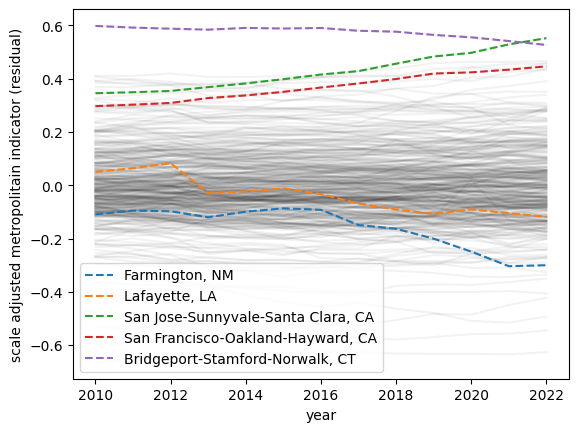

In [26]:
plt.clf()
sorted_resid_order = numpy.argsort(numpy.hstack([x[-1]-x[0] for x in resids]))
sorted_resid_order_initial = numpy.argsort(numpy.hstack([x[0] for x in resids]))
[plt.plot(years,resids[i],alpha=.05,color='k') for i in range(len(resids))]
plt.plot(years,resids[sorted_resid_order[0]],alpha=1,linestyle='--',label=all_year_cbsa_names[sorted_resid_order[0]])
plt.plot(years,resids[sorted_resid_order[1]],alpha=1,linestyle='--',label=all_year_cbsa_names[sorted_resid_order[1]])
plt.plot(years,resids[sorted_resid_order[-1]],alpha=1,linestyle='--',label=all_year_cbsa_names[sorted_resid_order[-1]])
plt.plot(years,resids[sorted_resid_order[-2]],alpha=1,linestyle='--',label=all_year_cbsa_names[sorted_resid_order[-2]])
plt.plot(years,resids[sorted_resid_order_initial[-1]],alpha=1,linestyle='--',label=all_year_cbsa_names[sorted_resid_order_initial[-1]])
plt.legend()
plt.xlabel('year')
plt.ylabel('scale adjusted metropolitain indicator (residual)')
plt.show()

We can find some interesting patterns in the SAMI trend for individual cities. First, since 2010 the biggest winners have been the two major cities that service the tech industry. We can see that Bridgeport, where many of the U.S. hedge funds are based has been overperforming consistently and only recently was overtaken by the San Jose Metro area. 

A quick wikipedia search reveals that Lafayette Louisiana is a major hub for the oil and gas industry. It is possible that the decrease we see is related to decreased oil prices after 2014/2015.

I wan't able to find anything obvious for Farmington, New Mexico.

It's also helpful to plot the residuals on a map:

In [27]:
cbsa_shapes = geopandas.read_file('data/usa_cbsa_shape/tl_2023_us_cbsa.shp')
cbsa_shapes['GEOID'] = cbsa_shapes['GEOID'].astype(str)
cbsa_shapes = cbsa_shapes[cbsa_shapes['GEOID'].isin(all_year_cbsa)]
cbsa_shapes['resids22'] = [numpy.array(resids)[all_year_cbsa.values ==cbsa].flatten()[-1] for cbsa in  cbsa_shapes['GEOID']]
cbsa_shapes['resids10'] = [numpy.array(resids)[all_year_cbsa.values ==cbsa].flatten()[0] for cbsa in  cbsa_shapes['GEOID']]
cbsa_shapes = cbsa_shapes[~cbsa_shapes['NAME'].str.contains(', PR')]

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


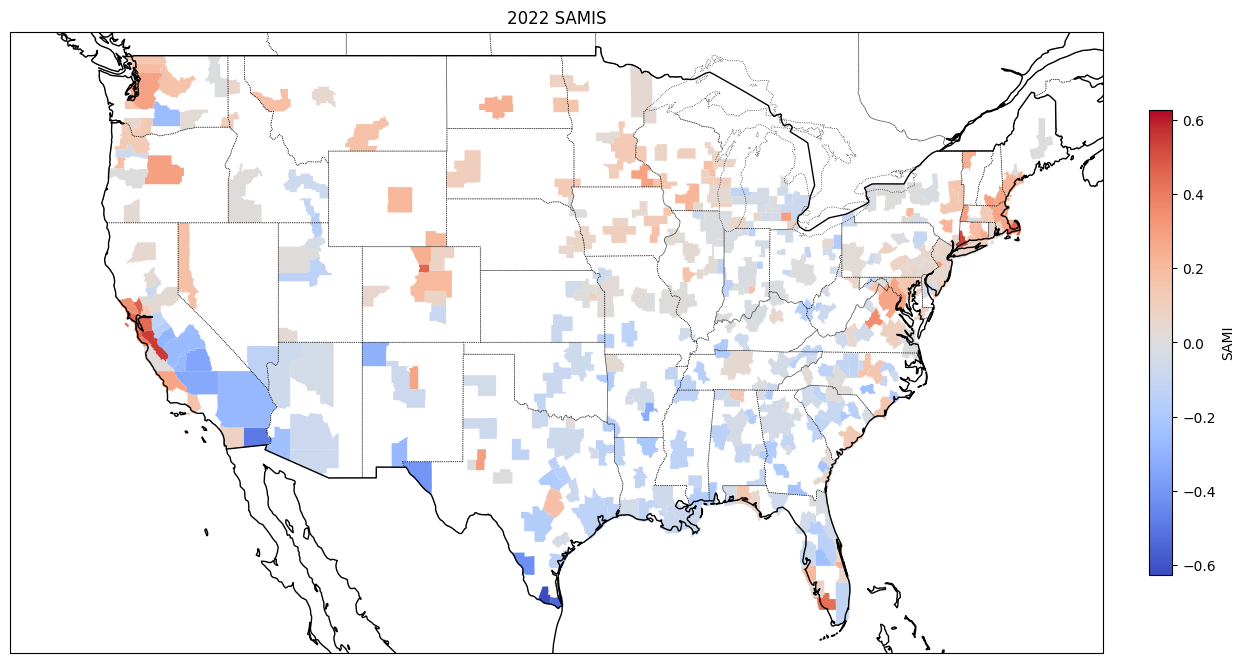

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


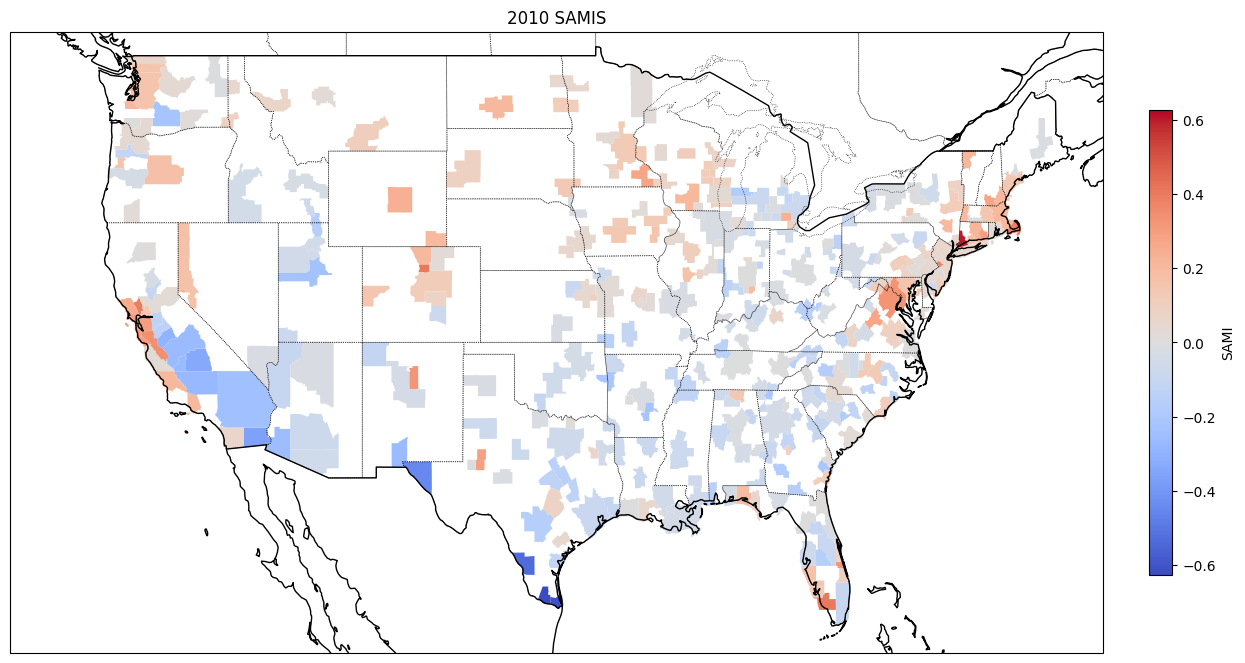

In [28]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)

vmin = cbsa_shapes['resids22'].min()
vmax = cbsa_shapes['resids22'].max()
vabs = max(abs(vmin), abs(vmax))
norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

cmap = plt.cm.get_cmap('coolwarm')

cbsa_shapes.plot(ax=ax, transform=ccrs.PlateCarree(), column='resids22', cmap=cmap, legend=False,norm=norm)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('SAMI')

ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())

plt.title('2022 SAMIS')
plt.show()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)

vmin = cbsa_shapes['resids22'].min()
vmax = cbsa_shapes['resids22'].max()
vabs = max(abs(vmin), abs(vmax))
norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

cmap = plt.cm.get_cmap('coolwarm')

cbsa_shapes.plot(ax=ax, transform=ccrs.PlateCarree(), column='resids10', cmap=cmap, legend=False,norm=norm)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('SAMI')

ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())

plt.title('2010 SAMIS')
plt.show()

There are very clear regional patterns in the residuals. Cities on the coasts, large cities, and northern midwest outperform relative to their size. 

In contrast, the south, central California, and western rockies states tend to be poorer performers relative to their size. 

One of the other interesting things we can do is look at other metrics besides income and compare the SAMIs. Here I do this for walkability from https://www.epa.gov/smartgrowth/smart-location-mapping#walkability

In [29]:
walk_data = pandas.read_csv('data/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')
walk_data = walk_data[~numpy.isnan(walk_data['CBSA'])].copy()
walk_data['CBSA'] = walk_data['CBSA'].astype(int).astype(str)

pop_data_usa['GEO_ID'] = pop_data_usa['GEO_ID'].map(lambda x: x.split('US')[-1])

In [30]:
walk_data = walk_data.groupby('CBSA')['NatWalkInd'].mean().reset_index().set_index('CBSA').join(usa_data[usa_data['year']==2021].set_index('GEO_ID'))
walk_data = walk_data.dropna()

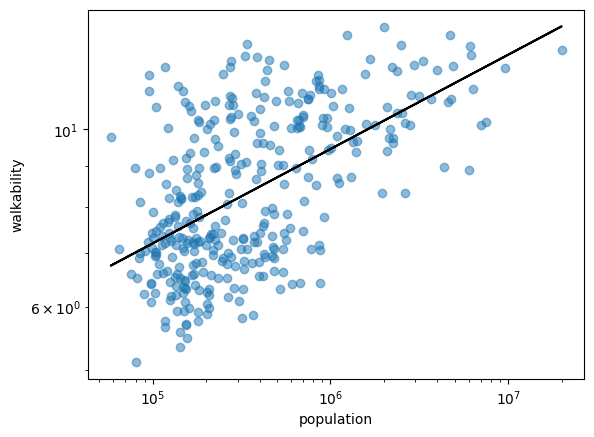

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NatWalkInd   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     163.6
Date:                Mon, 27 May 2024   Prob (F-statistic):           5.79e-31
Time:                        17:25:04   Log-Likelihood:                 94.949
No. Observations:                 350   AIC:                            -185.9
Df Residuals:                     348   BIC:                            -178.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6177      0.118      5.233      0.000       0.386       0.850
population     0.1179      0.009     12.789      0.000       0.100       0.136
==============================================================================
Omnibus:                       12.780   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.944
Skew:                           0.316   Prob(JB):                      0.00693
Kurtosis:                       2.467   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
walk_fit = OLS(numpy.log(walk_data['NatWalkInd'].astype(float)),
    add_constant(numpy.log(walk_data['population'].astype(float)))).fit()
income_fit = OLS(numpy.log(walk_data['aggregated_income'].astype(float)),
    add_constant(numpy.log(walk_data['population'].astype(float)))).fit()

plt.clf()
plt.scatter(walk_data['population'].astype(float),walk_data['NatWalkInd'].astype(float),alpha=.5)
plt.plot(walk_data['population'].astype(float),numpy.exp(walk_fit.fittedvalues),color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('population')
plt.ylabel('walkability')
plt.show()

walk_fit.summary()

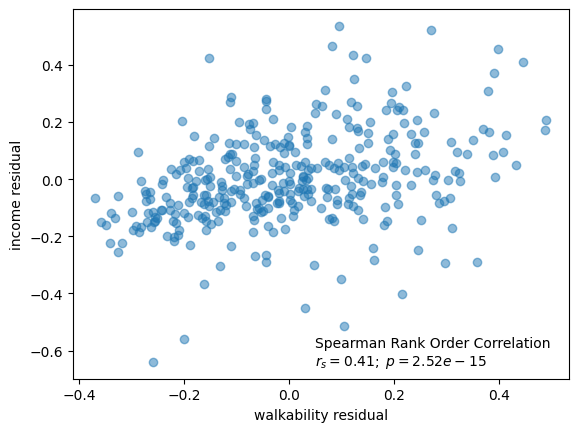

In [32]:
from scipy.stats import spearmanr
plt.clf()
plt.scatter(walk_fit.resid,income_fit.resid,alpha=.5)
plt.xlabel('walkability residual')
plt.ylabel('income residual')
rs = spearmanr(walk_fit.resid,income_fit.resid)
plt.text(.05,-.65,'Spearman Rank Order Correlation\n'+r'$r_s = %.2f;\ p=%.2e$' % (rs[0],rs[1]))
plt.show()

We find that the walkability and total income residuals are significantly correlated, though not partuclarly strongly. This suggests that cities that have more income than we would expect for their population also tend to be more walkable. It is interesting to think about whether this is a causal relationship, but we cannot directly test that with these data.

## 5. Boundaries

Next I want to return to the question of how we define boundaries of our units of analysis. We will start with cities, but I will suggest that this is also relevant in biological data.

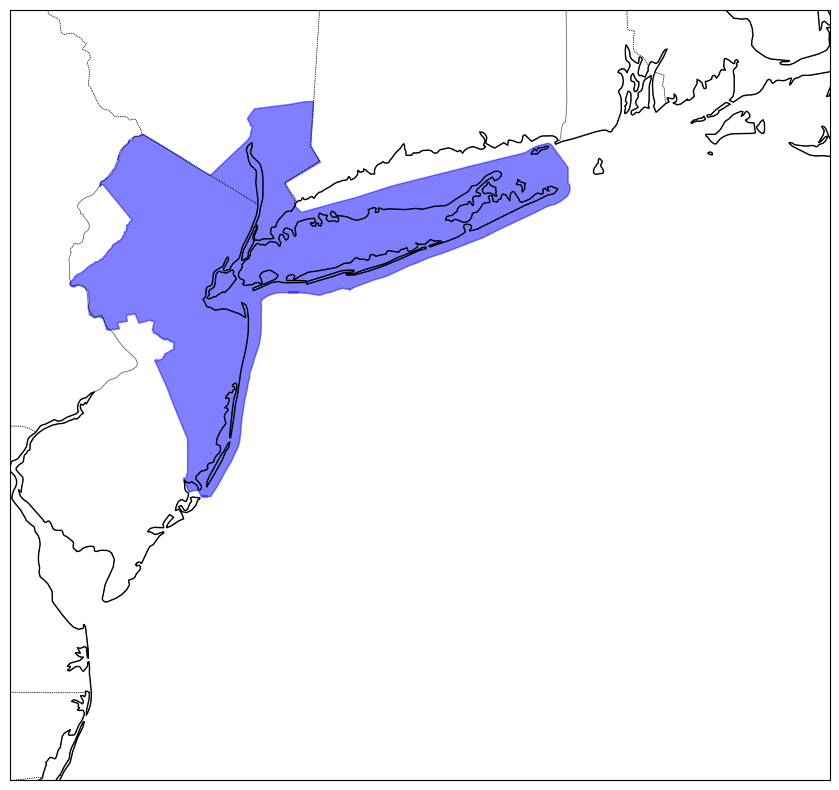

In [33]:
# Create a new plot with a specific projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features for the continental US boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)


cbsa_shapes[cbsa_shapes['NAME'].str.contains('New York')].plot(ax=ax, transform=ccrs.PlateCarree(), color='blue', edgecolor='blue',alpha=.5)

ax.set_extent([-75.6, -70, 38, 42], crs=ccrs.PlateCarree())

plt.show()

This is the boundary for the New York City Metro area. It covers much more land area than the administrative boundaries of NYC itself. We can just barely make out manhattan in the middle of the blue area. 

![title](omb_cbsa_def.png)

https://www.govinfo.gov/content/pkg/FR-2010-06-28/pdf/2010-15605.pdf

Like any other complex system, breaking a city down into its parts is non-trivial and we as of yet do not have good theory for how to define sub-components of cities that are general. Compare this to biology where, for example, we feel comfortable talking about organelles as distinct sub-components of cells.

As a result analyses can get weird when you do start breaking down cities into sub-components. Here is an example:

![title](depression_stier.png)

![title](boundary_huth_title.png)
![title](boundary_huth.png)


![title](boundary_stier.png)
![title](boundary_figure_response.png)

Let's look at some biological data on longevity.

In [34]:
aging_data = pandas.read_csv('data/anage_data.txt',sep='\t')
aging_data = aging_data[['Class','Common name','Adult weight (g)','Maximum longevity (yrs)']].dropna()

In [40]:
aging_data[(aging_data['Class']=="Mammalia")]

,Class,Common name,Adult weight (g),Maximum longevity (yrs)
1874,Mammalia,Lesser hedgehog tenrec,180.0,19.0
1876,Mammalia,Streaked tenrec,180.0,2.7
1877,Mammalia,Dobson's shrew tenrec,37.8,5.6
1878,Mammalia,Talazac's shrew tenrec,50.0,5.8
1879,Mammalia,Greater hedgehog tenrec,225.0,14.1
...,...,...,...,...
3215,Mammalia,Asian house shrew,45.9,3.2
3216,Mammalia,Star-nosed mole,55.3,2.5
3218,Mammalia,Japanese mole,97.0,3.2
3220,Mammalia,Eastern mole,90.0,6.2


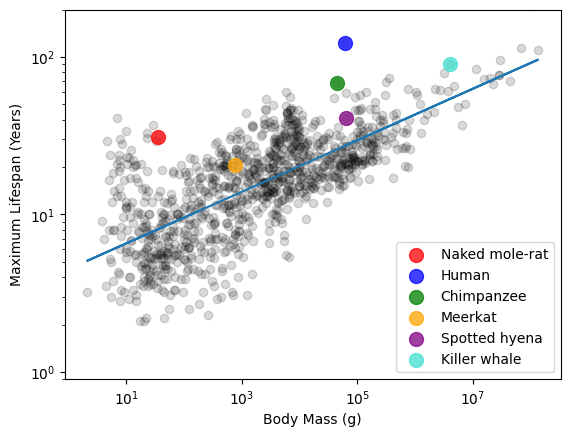

In [36]:
colors = {
    'Naked mole-rat': 'red',
    'Human': 'blue',
    'Chimpanzee': 'green',
    'Meerkat': 'orange',
    'Spotted hyena': 'purple',
    'Killer whale':'turquoise',
}

longevity_fit = RLM(numpy.log(aging_data[aging_data['Class'] == "Mammalia"]['Maximum longevity (yrs)']),
                    add_constant(numpy.log(aging_data[aging_data['Class'] == "Mammalia"]['Adult weight (g)']))).fit()
plt.clf()
plt.scatter(aging_data[aging_data['Class'] == "Mammalia"]['Adult weight (g)'],
            aging_data[aging_data['Class'] == "Mammalia"]['Maximum longevity (yrs)'], alpha=.15, color='k')

for animal, color in colors.items():
    plt.scatter(aging_data[aging_data['Common name'] == animal]['Adult weight (g)'],
                aging_data[aging_data['Common name'] == animal]['Maximum longevity (yrs)'], alpha=.75, s=100,
                label=animal, marker='o', color=color) 
plt.yscale('log')
plt.xscale('log')
plt.plot(aging_data[aging_data['Class'] == "Mammalia"]['Adult weight (g)'],numpy.exp(longevity_fit.fittedvalues))
plt.legend()
plt.ylim(.9, 200)
plt.xlabel('Body Mass (g)')
plt.ylabel('Maximum Lifespan (Years)')
plt.show()


This is longevity v.s. body mass and I've highlighted a number of social animals. Lets see what happens when we multiply the mass by the typical group size for these animals.

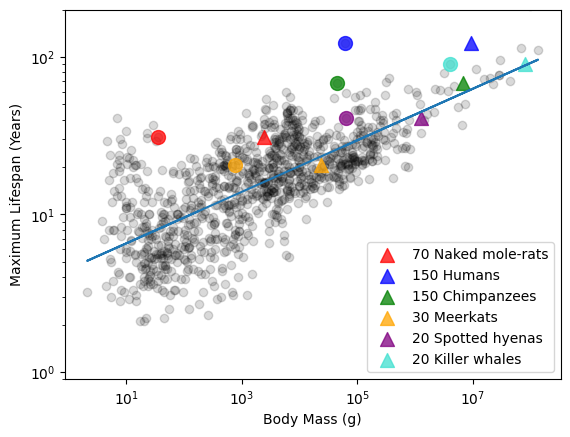

In [37]:
colors = {
    'Naked mole-rat': 'red',
    'Human': 'blue',
    'Chimpanzee': 'green',
    'Meerkat': 'orange',
    'Spotted hyena': 'purple',
    'Killer whale':'turquoise',
}

plt.clf()

plt.scatter(aging_data[aging_data['Class'] == "Mammalia"]['Adult weight (g)'],
            aging_data[aging_data['Class'] == "Mammalia"]['Maximum longevity (yrs)'], alpha=.15, color='k')

for animal, color in colors.items():
    plt.scatter(aging_data[aging_data['Common name'] == animal]['Adult weight (g)'],
                aging_data[aging_data['Common name'] == animal]['Maximum longevity (yrs)'], alpha=.75, s=100,
                marker='o', color=color)
    plt.scatter(aging_data[aging_data['Common name'] == animal]['Adult weight (g)'] *
                (70 if animal == 'Naked mole-rat' else 150 if animal == 'Human' else 150 if animal == 
                 'Chimpanzee' else 30 if animal == 'Meerkat' else 20 if animal== "Killer whale" else 20),
                aging_data[aging_data['Common name'] == animal]['Maximum longevity (yrs)'], alpha=.75, s=100,
                label=f"{'70 ' if animal == 'Naked mole-rat' else '150 ' if animal == 'Human' else '150 ' if animal == 'Chimpanzee' else '30 ' if animal == 'Meerkat' else '20 'if animal=='Killer whale' else '20 '}{animal}s",
                marker='^', color=color)

plt.yscale('log')
plt.xscale('log')
plt.plot(aging_data[aging_data['Class'] == "Mammalia"]['Adult weight (g)'],numpy.exp(longevity_fit.fittedvalues))
plt.legend()
plt.ylim(.9, 200)
plt.xlabel('Body Mass (g)')
plt.ylabel('Maximum Lifespan (Years)')
plt.show()


In most cases, except human and nake mole rates, accounting for the social group size brings the maximum lifespan closer to the best fit line for all mammals in the dataset. This suggests that for social species, the typical group might be a better unit of analysis than the individual. 

This is certaintly true for naked mole-rates who have a similar social structure to ants, bees, and termites, where the entire colony works to ensure the genetic sucess of a small number of individuals.

However, this hypothesis may not be the best explanation for why these animals have longer lifespans than expected.

## 6. Urban Data sources

#### City boundaries
- Global Human Settlement Layer (https://human-settlement.emergency.copernicus.eu/) Has global data on many things, including functional urban areas (similar to CBSAs), building heights, built up surfaces, etc.
- U.S. CBSA shape files (https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)
- OECD functional urban areas (https://www.oecd.org/regional/regional-statistics/functional-urban-areas.htm)

#### Misc Data
- U.S. Census (https://data.census.gov/) demographic and economic measures for cities and other geographies.
- Our World in Data (https://ourworldindata.org/) a good resource to explore trends across the world, some city data available.
- Walkability and other built environment metrics in the U.S. including street design and accessibility (https://www.epa.gov/smartgrowth/smart-location-mapping)

#### Get creative
- We have used data from twitter (X), smartphone apps, park surveys, crime reports, and online psychological tests to do various scaling analyses in cities.
